In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from skimage import draw
from skimage.transform import resize
from creating_movies import BasicMovieMaker
import tensorflow as tf
from tqdm.notebook import tqdm
from convolutional_models import BasicCNN, weighted_BCE, balanced_accuracy
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, MaxPooling2D, UpSampling2D, concatenate, Dropout, TimeDistributed, Concatenate
from tensorflow.keras.layers import LSTM, Flatten, Reshape
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

plt.rcParams['animation.convert_path'] = 'D:/ImageMagick-7.0.9-Q16/magick.exe' # Hack for windows

In [2]:
Concatenate?

In [3]:
TimeDistributed?

In [4]:

def forward_block_td(inp, no_filter, kernel_size=(3,3), activation='relu', drp=0.25):
    skip = TimeDistributed(Conv2D(no_filter, kernel_size, padding='same'))(inp)
    x = TimeDistributed(Activation(activation))(skip)
    x = TimeDistributed(Dropout(drp))(x)
    x = TimeDistributed(MaxPooling2D(strides=2))(x)

    return x, skip


def backward_block_td(inp, skip, no_filter, kernel_size=(3,3), activation='relu', drp=0.25):
    x = TimeDistributed(Conv2DTranspose(no_filter, kernel_size, strides=(2,2), padding='same'))(inp)
    x = Concatenate()([x, skip])
    x = TimeDistributed(Conv2D(no_filter, kernel_size, padding='same'))(x)
    x = TimeDistributed(Activation(activation))(x)
    x = TimeDistributed(Dropout(drp))(x)

    return x

class BasicLSTM:

    def __init__(self, image_shape, img_channels):
        self.channels = img_channels + 1
        self.image_shape = image_shape

    def make_model(self):

        inp = Input(shape=[*self.image_shape, self.channels])
        x, c1 = forward_block_td(inp, 8) # 112
        x, c2 = forward_block_td(x, 16) # 56
        x, c3 = forward_block_td(x, 32) # 28
        x, c4 = forward_block_td(x, 64) # 14
        x, c5 = forward_block_td(x, 16) # 7
        
        x = TimeDistributed(Flatten())(x)
        x = LSTM(7*7*16, return_sequences=True)(x)
        x = TimeDistributed(Reshape( ( 7, 7, 16)))(x)
        x = Activation('relu')(x)

        x = backward_block_td(x, c5, 128) # 7
        x = backward_block_td(x, c4, 64) # 14
        x = backward_block_td(x, c3, 32) # 28
        x = backward_block_td(x, c2, 16) # 56
        x = backward_block_td(x, c1, 8) # 112
        
        x = TimeDistributed(Conv2D(1, (1,1), padding='same'))(x)
        out = Activation('sigmoid')(x)

        model = Model(inputs=inp, outputs=out)

        return model


In [5]:
LSTM?

In [6]:
# Create data:
X = []
Y = []
targ = []
for ii in range(100):
    SMO = BasicMovieMaker()
    SMO.make_objects(np.random.randint(5, 25))
    movie, target, masks = SMO.make_movie(np.random.randint(5, 15))

    X.append(movie)
    Y.append(masks)
    targ.append(target)

In [7]:
targ[0].shape

(9, 224, 224)

In [8]:
7 * 7 * 16

784

In [9]:
112 * 112 * 5

62720

In [10]:
cnn_basic = BasicLSTM((None, 224, 224), 1)

model = cnn_basic.make_model()
model.compile(loss=weighted_BCE, optimizers=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy', balanced_accuracy])

In [11]:
for n in range(3):
    for ii in tqdm(range(99)):
        tmp_targ = targ[ii].copy()
        tmp_targ[1:] = 0
        one_batch = np.concatenate([X[ii][:,:,:, None], tmp_targ[:,:,:,None]], -1)[None, :, :, :, :]
        one_y = Y[ii][None, :, :, :, None]

        model.fit(one_batch, one_y, verbose=0)

In [42]:
t1 = -2
tmp_targ = targ[t1].copy()
tmp_targ[1:] = 0
one_batch = np.concatenate([X[t1][:,:,:, None], tmp_targ[:,:,:,None]], -1)[None, :, :, :, :]
one_y = Y[t1][None, :, :, :, None]


In [43]:
model.evaluate(one_batch, one_y)

1/1 [==============================] - 0s 299ms/sample - loss: 0.3319 - accuracy: 0.6484 - balanced_accuracy: 0.8201


[0.3319491744041443, 0.64842325, 0.8201102]

In [44]:
pred = model.predict(one_batch)

In [45]:
pred = np.squeeze(pred)

<IPython.core.display.Javascript object>


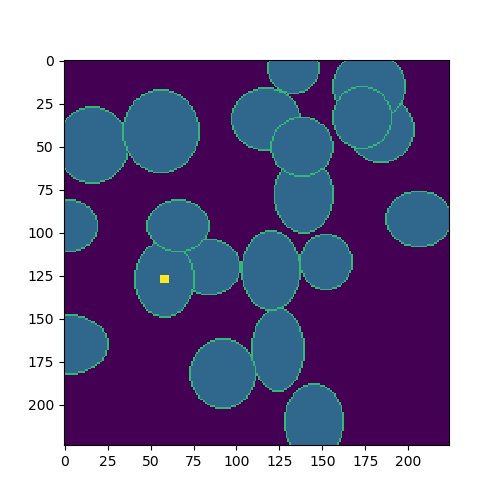

(<Figure size 500x500 with 0 Axes>,
 <matplotlib.animation.FuncAnimation at 0x1aed0b408>)

In [52]:
%matplotlib notebook
SMO.play_movie(np.squeeze(one_batch[:,:,:,:, 0]), 
               np.squeeze(targ[t1]), 
               pred > 10, f_size=(5,5))

In [39]:
one_batch[:,:,:,:, 1].sum(0).sum(-1).sum(-1)

array([25.,  0.,  0.,  0.,  0.,  0.,  0.])